# E8프로젝트 : 인물모드 문제점 찾기
- 스마트폰에 있는, 인물을 제외한 배경을 블러처리하는 인물사진모드를 구현해보자

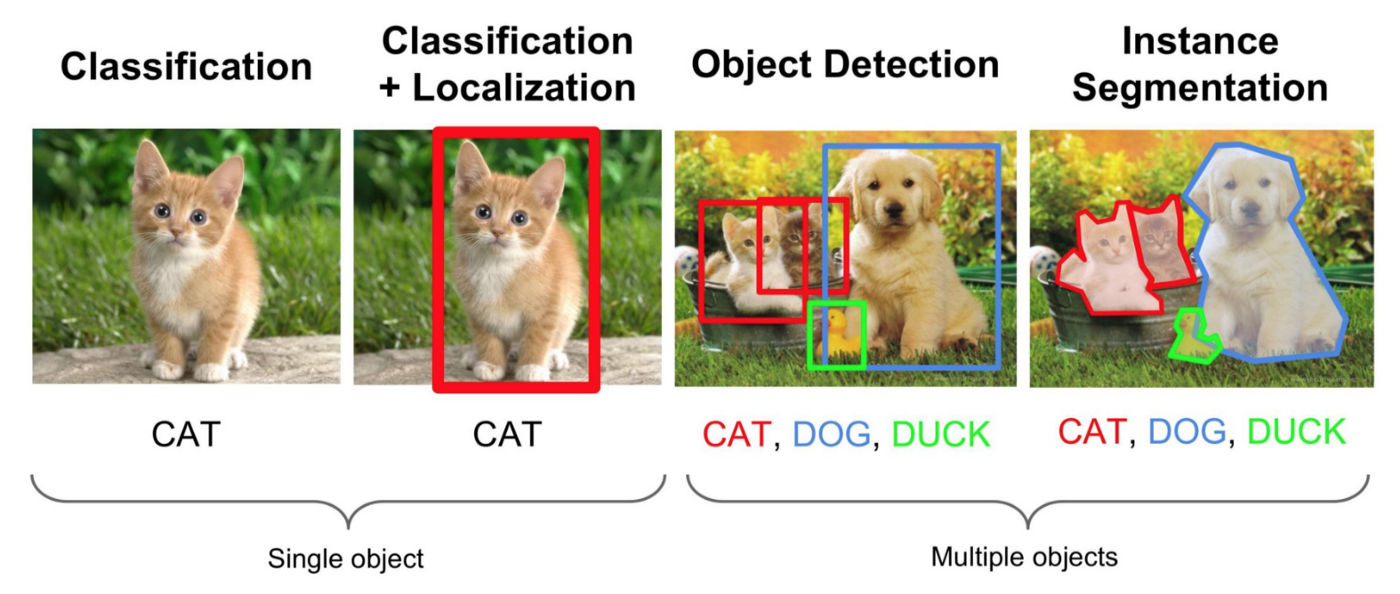
[출처](https://medium.com/zylapp/review-of-deep-learning-algorithms-for-object-detection-c1f3d437b852) 

## Semantic Segmentation 이해하기
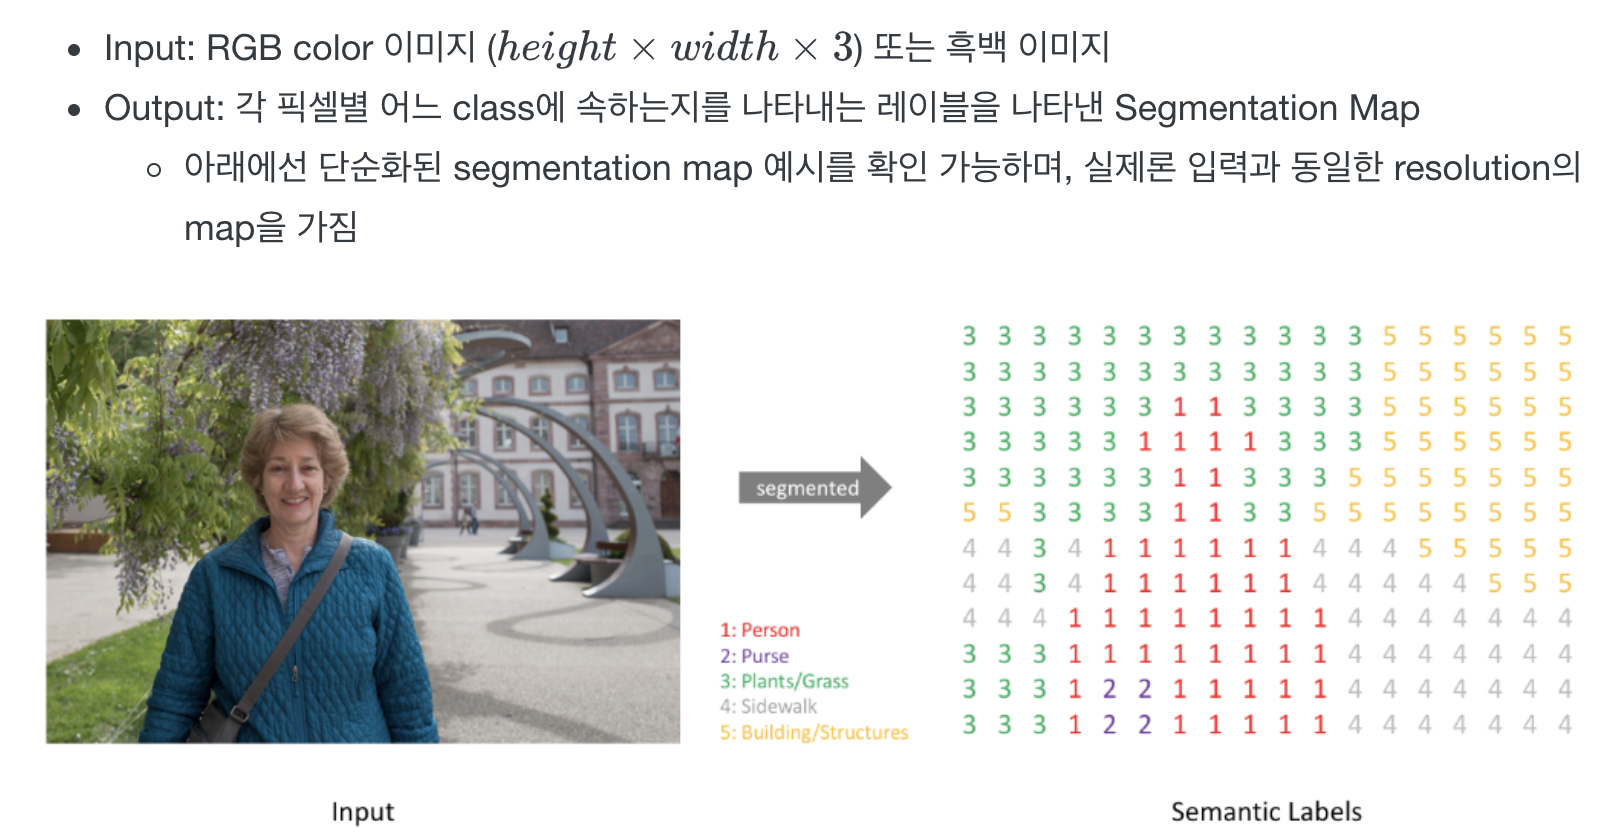

<br />

[출처](https://seongkyun.github.io/study/2019/12/08/segmentation/)

# - 목차 - 

### Step 1. 인물모드 직접 해 보기   

#### 1-1. 사람 이미지 검출    

#### 1-2. 고양이 이미지 검출    

#### 1-3. 강아지 이미지 검출    

#### 1-4. 크로마키 해보기

### Step 2. 사진에서 문제점 찾기    
### Step 3. 해결 방법을 제안해 보기

## Step 1. 인물모드 직접 해 보기

In [1]:
import cv2
import numpy as np
import os
import tarfile
import urllib #웹에서 데이터를 다운로드할때 사용

from matplotlib import pyplot as plt
import tensorflow as tf

### 1-1. 사람 이미지 검출

In [2]:
import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/image8.jpeg'  
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(545, 403, 3)


In [3]:
# 구글에서 Tensorflow V1으로 작성한 DeepLab모델 구조를 그대로 가져와 활용
# DeepLab이라는 세그멘테이션 모델을 만들고 모델에 이미지를 입력
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read()) # tf.compat.v1 - Tensorflow V2에서 V1코드와 모델 구조를 활용할 수 있도록 제공
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)
        
    
    # preprocess()는 전처리 하는 함수
    
    # 먼저 input tensor를 만들기 위해 preprocess() 함수에서 이미지를 전처리
    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height) # 모델이 받는 입력 크기가 정해져 있으므로 이에 따라 적절한 크기로 resize 
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB) # OpenCV의 디폴트 BGR 채널 순서를 텐서플로우에 맞는 RGB로 수정
        img_input = resized_rgb
        return img_input
    
    # 실제로 세그멘테이션 하는 함수    
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

사전에 학습된 가중치(pretrained weight)를 불러오기

In [4]:
# 구글에서 제공하는 파일을 다운로드
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


In [5]:
# 첫 단계에서 준비한 이미지를 네트워크에 입력
# cv2는 이미지를 HWC(Height, Width, Channel) 순서로 표시한다는 점!!
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max()) #seg_map.max() : 세그멘테이션 맵에서 가장 큰 값(물체로 인식된 라벨 중 가장 큰 값)

(545, 403, 3) (513, 379, 3) 15


구글이 제공한 DeepLab은 PASCAL VOC의 라벨로 학습되었음

In [6]:
# 아래는 제공하는 라벨 종류
# 위에서 seg_map.max()값이 15가 나왔는데 이 15는 무엇을 의미하냐면
# 아래의 label names에서 15번째인 person인 것을 알 수 있음
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

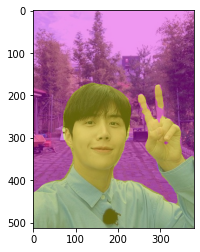

In [7]:
# 사람만 검출해내고 싶기 때문에 
# 사람(person) 라벨, 즉 15를 가진 영역만 검출
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 일반 이미지는 0부터 255 까지의 값을 사용해 픽셀을 표현하므로, 세그멘테이션 맵에 표현된 값을 원본 이미지에 그림 형태로 출력하기 위해 255로 정규화 
img_mask = img_mask.astype(np.uint8)
# cv2.applyColorMap - 제공되는 칼라맵을 적용하여 색감을 완전히 변화시킬 수 있음
# 색을 적용하고 이미지를 화면에 출력
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_SPRING) # 기본 COLORMAP_JET은 잘 안보여서 COLORMAP_SPRING으로 바꿈
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

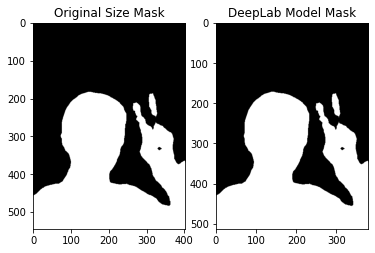

In [8]:
# DeepLab 모델을 사용하기 위해 이미지 크기를 작게 resize 해서 입력했음
# 따라서 출력도 resize 된 입력 크기와 같게 나오게 됨
# 세그멘테이션 결과(mask)를 원래 크기로 복원
# cv2.INTER_NEAREST를 이용해서 깔끔하게 처리할 수 있지만 더 정확히 확대하기 위해 cv2.INTER_LINEAR 를 사용
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR) # 크기를 키울 때 보간(interpolation) 을 고려
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)
# img_mask_up 은 경계가 블러된 픽셀값 0~255의 이미지를 얻는데 확실한 경계를 다시 정하기 위해 중간값인 128을 기준으로 임계값(threshold)을 설정
# 128 이하의 값은 0으로 128 이상의 값은 255로 만드는 방법임

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

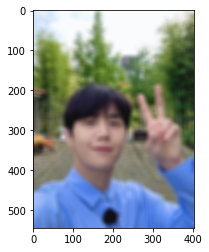

In [9]:
# blur()함수를 이용해서 배경을 흐리게 만들기
img_orig_blur = cv2.blur(img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻함 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

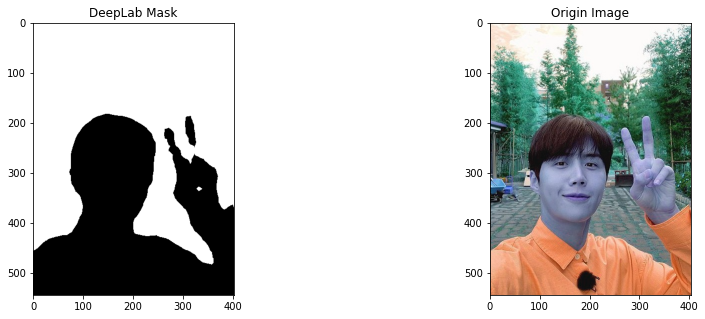

In [13]:
# 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color) # bitwise_not 함수를 이용하면 이미지가 반전 ->  배경은 255 사람은 0
img_bg = cv2.bitwise_and(img_orig_blur, img_bg_mask)

fig = plt.figure(figsize=(15, 5)) 

ax = plt.subplot(1,2,1)
plt.imshow(img_bg_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_orig, cmap=plt.cm.binary_r)
ax.set_title('Origin Image')

plt.show()


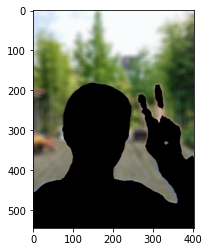

In [14]:
#bitwise 결과
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

Text(0.5, 1.0, 'Blur Processing')

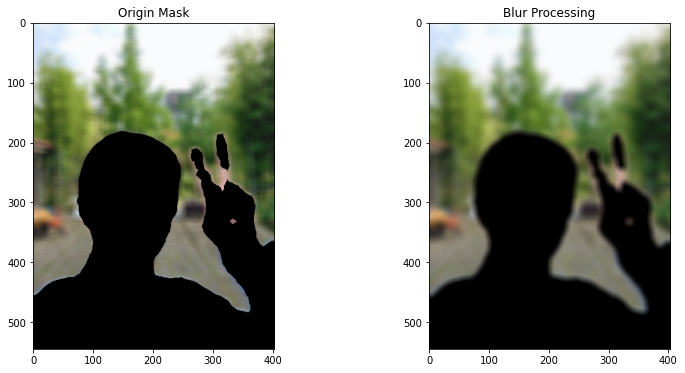

In [15]:
# 이 이미지를 블러(blur)하면 배경이 흐리게 처리된 영상을 얻을 수 있습니다.
img_bg_blur = cv2.blur(img_bg, (12,12))

fig = plt.figure(figsize=(13, 6)) 

ax = plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img_bg, cv2.COLOR_BGR2RGB), cmap=plt.cm.binary_r)
ax.set_title('Origin Mask')

ax = plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB), cmap=plt.cm.binary_r)
ax.set_title('Blur Processing')

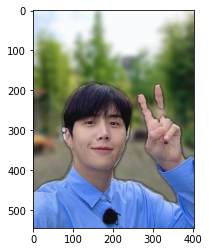

In [16]:
# 배경 영상과 사람 영상을 합치기
# 세그멘테이션 마스크가 255인 부분만 원본 영상을 가지고 오고 반대인 영역은 블러된 이미지 값을 사용
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

손가락이 잘려서 나옴ㅜㅜ

### 1-2. 고양이 이미지 검출

In [12]:
img_path2 = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat.jpeg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path2) 
print (img_orig.shape)

(753, 620, 3)


In [14]:
# 사전에 학습된 가중치(pretrained weight)를 불러오기
# 구글에서 제공하는 파일을 다운로드
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


In [15]:
# 첫 단계에서 준비한 이미지를 네트워크에 입력
# cv2는 이미지를 HWC(Height, Width, Channel) 순서로 표시한다는 점!!
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max()) #seg_map.max() : 세그멘테이션 맵에서 가장 큰 값(물체로 인식된 라벨 중 가장 큰 값)

(753, 620, 3) (513, 422, 3) 8


In [16]:
# 구글이 제공한 DeepLab은 PASCAL VOC의 라벨로 학습되었습니다. 아래는 제공하는 라벨 종류
# 위에서 8는 cat 이라는 것을 알 수 있음
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

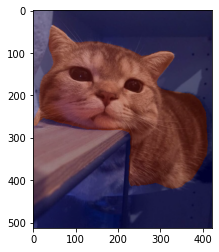

In [17]:
# 고양이 라벨, 즉 8를 가진 영역만 검출
img_show = img_resized.copy()
seg_map = np.where(seg_map == 8, 8, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 일반 이미지는 0부터 255 까지의 값을 사용해 픽셀을 표현하므로, 세그멘테이션 맵에 표현된 값을 원본 이미지에 그림 형태로 출력하기 위해 255로 정규화 
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET) # 색을 적용하고 이미지를 화면에 출력
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

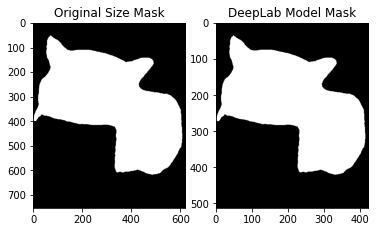

In [18]:
# DeepLab 모델을 사용하기 위해 이미지 크기를 작게 resize 해서 입력했음
# 따라서 출력도 resize 된 입력 크기와 같게 나오게 됨
# 세그멘테이션 결과(mask)를 원래 크기로 복원
# cv2.INTER_NEAREST를 이용해서 깔끔하게 처리할 수 있지만 더 정확히 확대하기 위해 cv2.INTER_LINEAR 를 사용
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR) # 크기를 키울 때 보간(interpolation) 을 고려
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)
# img_mask_up 은 경계가 블러된 픽셀값 0~255의 이미지를 얻는데 확실한 경계를 다시 정하기 위해 중간값인 128을 기준으로 임계값(threshold)을 설정
# 128 이하의 값은 0으로 128 이상의 값은 255로 만드는 방법임

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

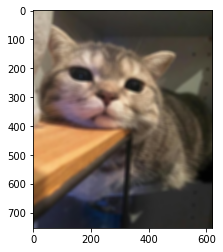

In [19]:
# blur()함수를 이용해서 배경을 흐리게 만들기
img_orig_blur = cv2.blur(img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻함 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

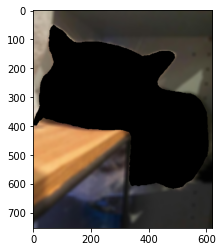

In [20]:
# 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color) # bitwise_not 함수를 이용하면 이미지가 반전 ->  배경은 255 사람은 0
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

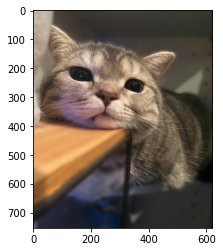

In [21]:
# 배경 영상과 사람 영상을 합치기
# 세그멘테이션 마스크가 255인 부분만 원본 영상을 가지고 오고 반대인 영역은 블러된 이미지 값을 사용
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 1-3. 강아지 이미지 검출

In [24]:
img_path3 = os.getenv('HOME')+'/aiffel/human_segmentation/images/dog.jpeg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path3) 
print (img_orig.shape)

(666, 499, 3)


In [27]:
# 첫 단계에서 준비한 이미지를 네트워크에 입력
# cv2는 이미지를 HWC(Height, Width, Channel) 순서로 표시한다는 점!!
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max()) #seg_map.max() : 세그멘테이션 맵에서 가장 큰 값(물체로 인식된 라벨 중 가장 큰 값)

(666, 499, 3) (513, 384, 3) 12


In [28]:
# 구글이 제공한 DeepLab은 PASCAL VOC의 라벨로 학습되었습니다. 아래는 제공하는 라벨 종류
# 위에서 12는 dog 이라는 것을 알 수 있음
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

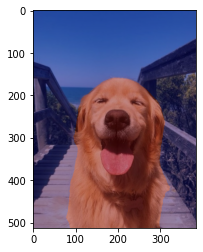

In [29]:
# 강아지 라벨, 즉 12를 가진 영역만 검출
img_show = img_resized.copy()
seg_map = np.where(seg_map == 12, 12, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 일반 이미지는 0부터 255 까지의 값을 사용해 픽셀을 표현하므로, 세그멘테이션 맵에 표현된 값을 원본 이미지에 그림 형태로 출력하기 위해 255로 정규화 
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET) # 색을 적용하고 이미지를 화면에 출력
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

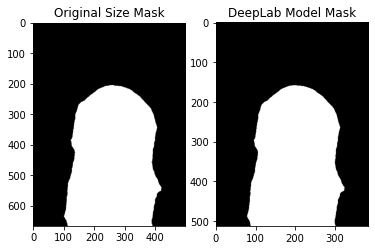

In [30]:
# DeepLab 모델을 사용하기 위해 이미지 크기를 작게 resize 해서 입력했음
# 따라서 출력도 resize 된 입력 크기와 같게 나오게 됨
# 세그멘테이션 결과(mask)를 원래 크기로 복원
# cv2.INTER_NEAREST를 이용해서 깔끔하게 처리할 수 있지만 더 정확히 확대하기 위해 cv2.INTER_LINEAR 를 사용
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR) # 크기를 키울 때 보간(interpolation) 을 고려
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)
# img_mask_up 은 경계가 블러된 픽셀값 0~255의 이미지를 얻는데 확실한 경계를 다시 정하기 위해 중간값인 128을 기준으로 임계값(threshold)을 설정
# 128 이하의 값은 0으로 128 이상의 값은 255로 만드는 방법임

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

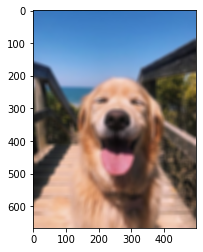

In [31]:
# blur()함수를 이용해서 배경을 흐리게 만들기
img_orig_blur = cv2.blur(img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻함 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

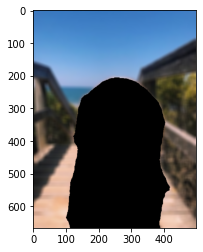

In [32]:
# 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color) # bitwise_not 함수를 이용하면 이미지가 반전 ->  배경은 255 사람은 0
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

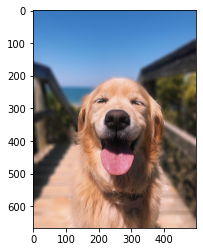

In [33]:
# 배경 영상과 사람 영상을 합치기
# 세그멘테이션 마스크가 255인 부분만 원본 영상을 가지고 오고 반대인 영역은 블러된 이미지 값을 사용
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 1-4. 크로마키 해보기(강아지 사진이랑 하늘 배경 합성)

In [35]:
img_path4 = os.getenv('HOME')+ '/aiffel/human_segmentation/images/image11.jpeg' # 사진이 저장된 경로 
img_sky = cv2.imread(img_path4) 
print (img_sky.shape)

(832, 468, 3)


In [41]:
target_size = img_orig.shape[:2][::-1]
resized_sky_image = cv2.resize(img_sky, target_size)
print(resized_sky_image.shape)

(666, 499, 3)


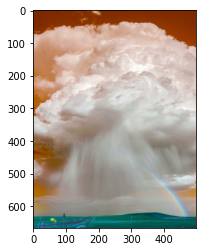

In [39]:
plt.imshow(resized_sky_image)
plt.show()

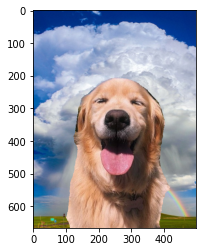

In [40]:
img_concat = np.where(img_mask_color==255, img_orig, resized_sky_image)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## Step 2. 사진에서 문제점 찾기

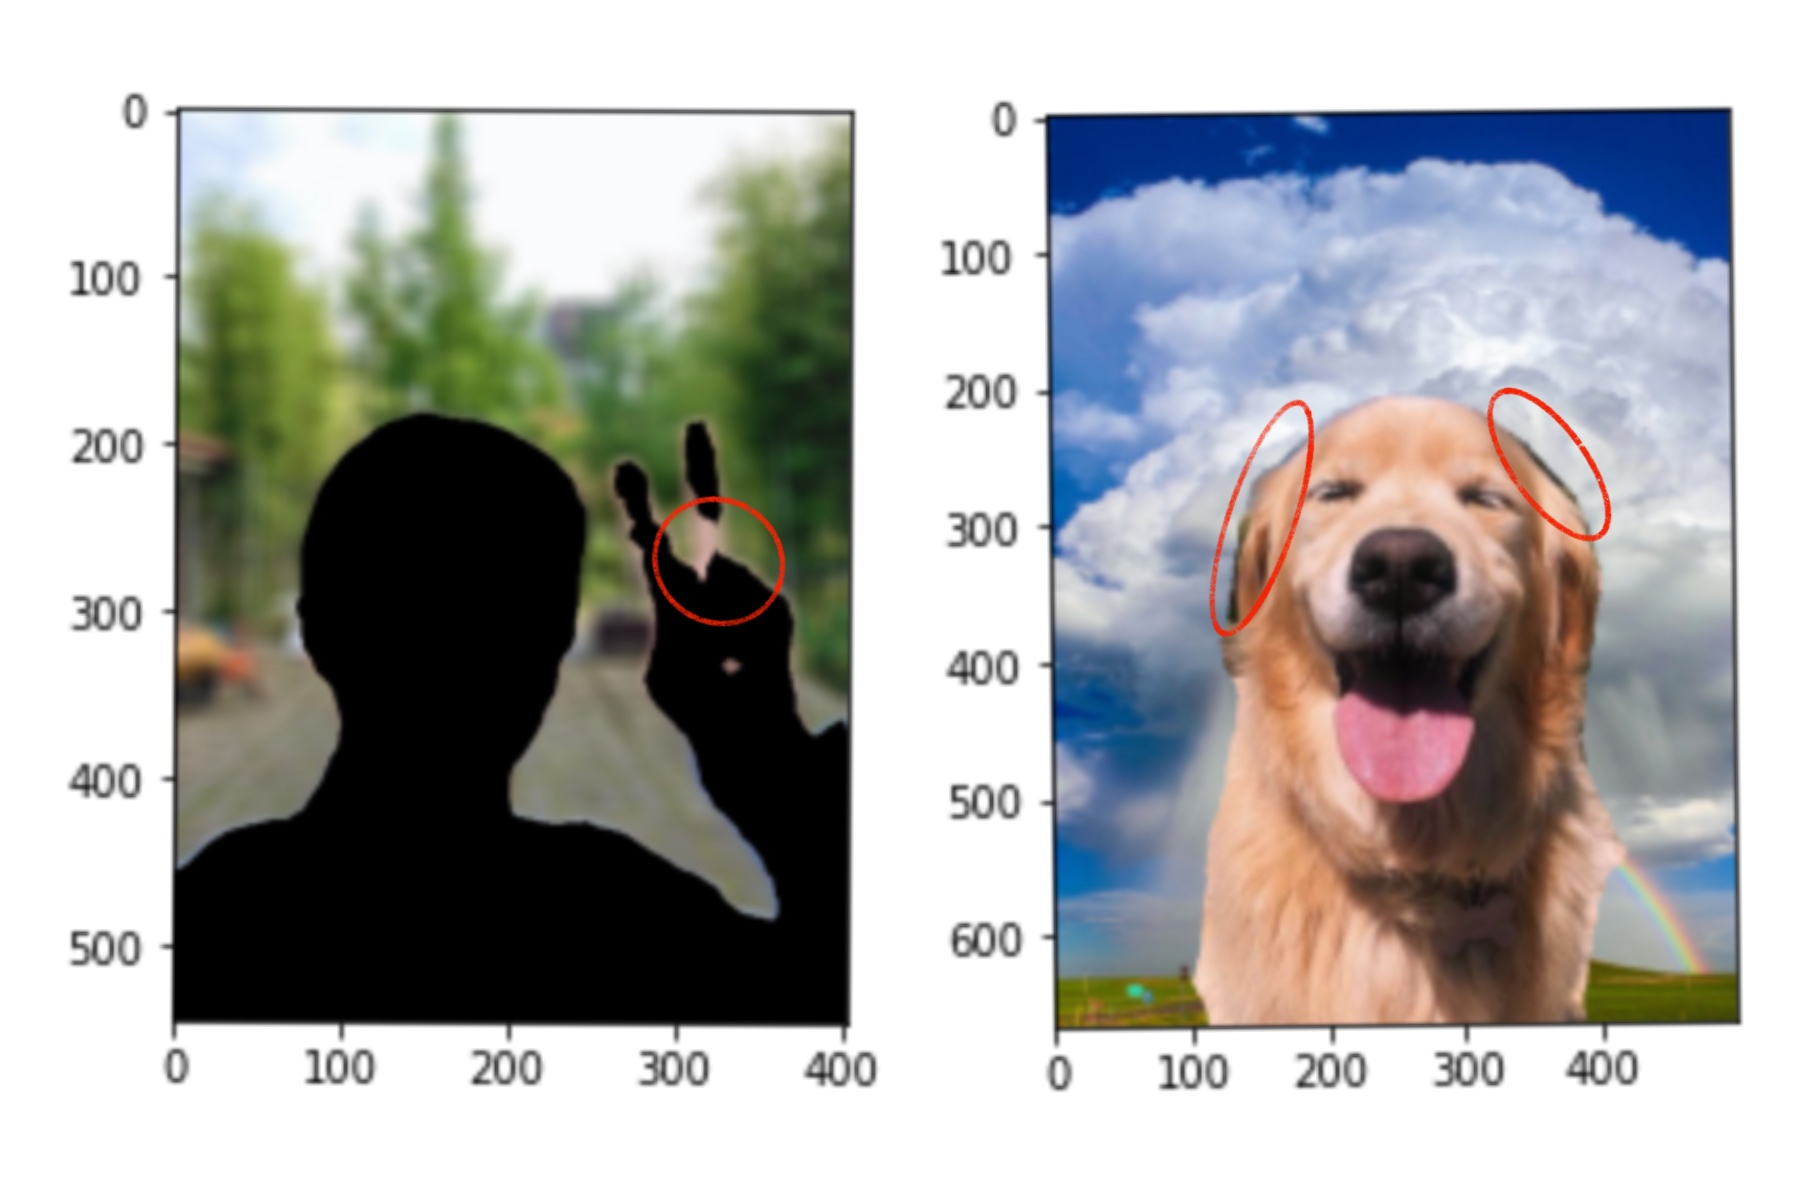

* ###  인물사진에서는 손 부분이 제대로 다 인식이 안돼서 배경과 같이 블러처리가 되었고 강아지 사진에서도 깔끔하게 강아지 모습만 검출이 되지 않은 것을 볼 수 있었다.

## Step 3. 해결 방법을 제안해 보기

## 해결방안 1)

### 가우시안 Blur 사용해보기
-> 경계선이 깔끔하게 나누어져있지 않은데 너무 잘보여서 사용   

[PEBpung](https://github.com/PEBpung/Aiffel/blob/master/Project/Exploration/E14.%20Image%20segmentation%EC%9D%84%20%EC%9D%B4%EC%9A%A9%ED%95%9C%20Portrait%20mode%20%EB%A7%8C%EB%93%A4%EA%B8%B0..ipynb)님의 깃허브를 참고하였습니다.

In [36]:
seonho_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/image99.jpeg'  
seonho_orig = cv2.imread(seonho_img_path) 
print (seonho_orig.shape)

(1350, 1080, 3)


In [37]:
#첫 단계에서 준비한 이미지를 네트워크에 입력
# cv2는 이미지를 HWC(Height, Width, Channel) 순서로 표시한다는 점!!
seonho_img_resized, seg_map = MODEL.run(seonho_orig)
print (seonho_orig.shape, seonho_img_resized.shape, seg_map.max()) #seg_map.max() : 세그멘테이션 맵에서 가장 큰 값(물체로 인식된 라벨 중 가장 큰 값)

(1350, 1080, 3) (513, 410, 3) 16


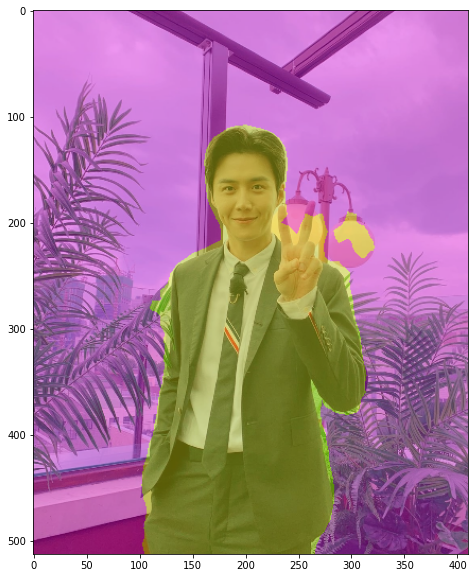

In [38]:
# 사람만 검출해내고 싶기 때문에 
# 사람(person) 라벨, 즉 15를 가진 영역만 검출
seonho_img_show = seonho_img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
seonho_img_mask = seg_map * (255/seg_map.max()) # 일반 이미지는 0부터 255 까지의 값을 사용해 픽셀을 표현하므로, 세그멘테이션 맵에 표현된 값을 원본 이미지에 그림 형태로 출력하기 위해 255로 정규화 
seonho_img_mask = seonho_img_mask.astype(np.uint8)
# cv2.applyColorMap - 제공되는 칼라맵을 적용하여 색감을 완전히 변화시킬 수 있음
# 색을 적용하고 이미지를 화면에 출력
seonho_color_mask = cv2.applyColorMap(seonho_img_mask, cv2.COLORMAP_SPRING) # 기본 COLORMAP_JET은 잘 안보여서 COLORMAP_SPRING으로 바꿈
img_show = cv2.addWeighted(seonho_img_show, 0.6, seonho_color_mask, 0.35, 0.0)

fig = plt.figure(figsize=(20, 10))
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### 마스크 뽑아내기

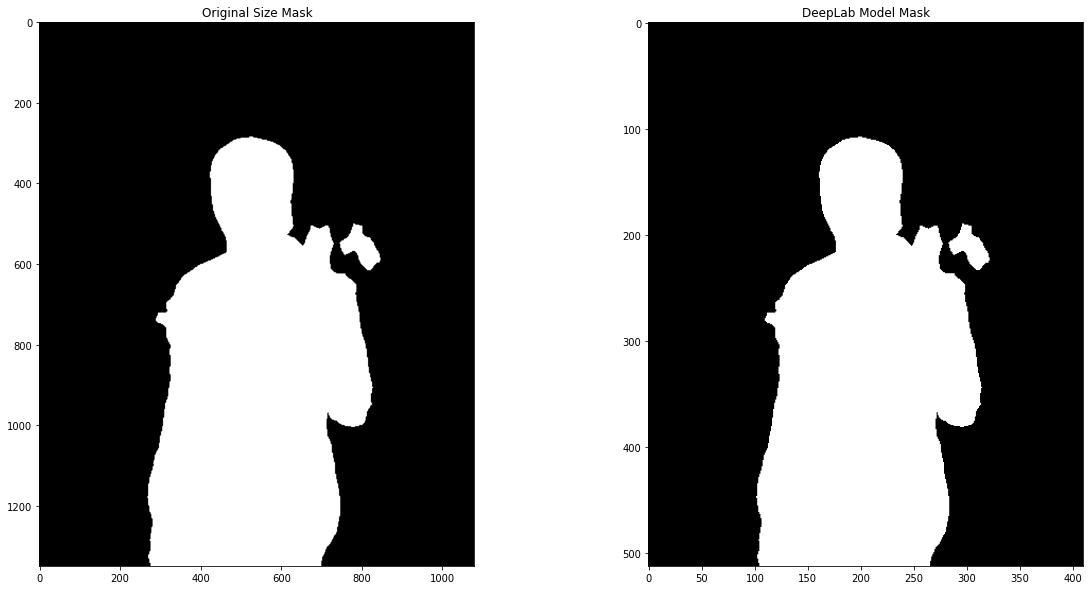

In [39]:
seonho_img_mask_up = cv2.resize(seonho_img_mask, seonho_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR) 
_, seonho_img_mask_up = cv2.threshold(seonho_img_mask_up, 128, 255, cv2.THRESH_BINARY)

fig = plt.figure(figsize=(20, 10))
ax = plt.subplot(1,2,1)
plt.imshow(seonho_img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(seonho_img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

### segmentation활용해서 배경만 추출하기

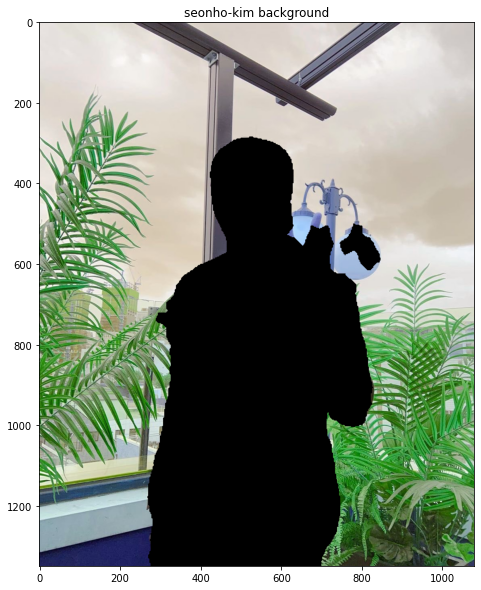

In [40]:
seonho_img_mask_color = cv2.cvtColor(seonho_img_mask_up, cv2.COLOR_GRAY2BGR)
seonho_img_bg_mask = cv2.bitwise_not(seonho_img_mask_color)
seonho_img_bg = cv2.bitwise_and(seonho_orig, seonho_img_bg_mask)

fig = plt.figure(figsize=(20, 10))

ax = plt.subplot(1,1,1)
plt.imshow(seonho_img_bg, cmap=plt.cm.binary_r)
ax.set_title('seonho-kim background')


plt.show()

Text(0.5, 1.0, 'Blur Processing')

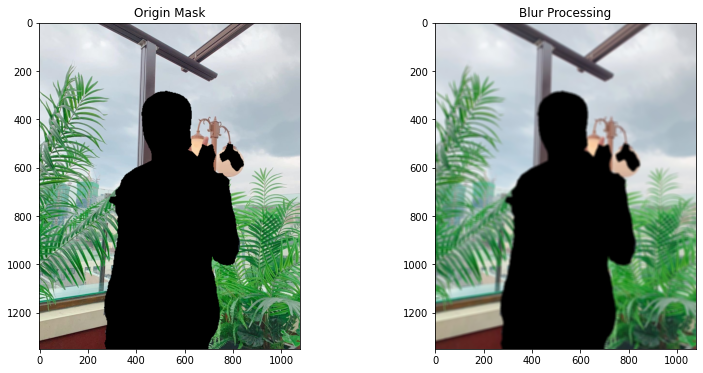

In [41]:
seonho_img_bg_blur = cv2.blur(seonho_img_bg, (12,12))

fig = plt.figure(figsize=(13, 6)) 

ax = plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(seonho_img_bg, cv2.COLOR_BGR2RGB), cmap=plt.cm.binary_r)
ax.set_title('Origin Mask')

ax = plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(seonho_img_bg_blur, cv2.COLOR_BGR2RGB), cmap=plt.cm.binary_r)
ax.set_title('Blur Processing')

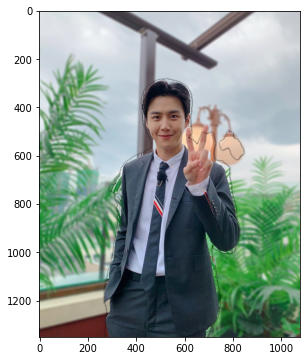

In [42]:
seonho_img_concat = np.where(seonho_img_mask_color==255, seonho_orig, seonho_img_bg_blur)
fig = plt.figure(figsize=(16, 6)) 
plt.imshow(cv2.cvtColor(seonho_img_concat, cv2.COLOR_BGR2RGB))
plt.show()

제대로 영역을 인식 못하고 경계선이 깔끔하지 못함ㅜㅜㅜ

### 가우시안 블러 적용해보기

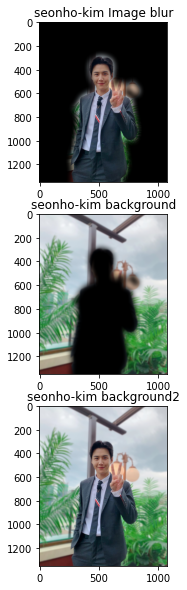

In [43]:
# 원본 사진과 마스크의 크기를 맞춰줌
seonho_img_mask_up = cv2.resize(seonho_img_mask, seonho_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
# 채널을 원본 사진과 맞게 3 channel로 바꾼다.
seonho_img_mask_3C = np.repeat(np.expand_dims(seonho_img_mask_up, axis=2), 3, axis=2).astype(np.uint8)

# 원본 이미지를 가우시안 Blur 처리한다.
seonho_img_orig_blur = cv2.GaussianBlur(seonho_orig, (25,25),0)
# 마스크 이미지를 가우시안 Blur 처리한다.
seonho_img_Gmask = (cv2.GaussianBlur(seonho_img_mask_3C, (101, 101), 25, 25)/255).astype(np.float32)

# 마스크와 이미지를 더해준다.
seonho_img_image_blur = seonho_img_Gmask*seonho_orig.astype(np.float32)
# 1-마스크를 해주는 이유는 Blur 처리한 원본에서 배경만 뽑아내기 위해서이다.
seonho_img_bg_mask = (1-seonho_img_Gmask)*seonho_img_orig_blur.astype(np.float32)
out = (seonho_img_image_blur+seonho_img_bg_mask).astype(np.uint8)

fig = plt.figure(figsize=(20, 10)) 

ax = plt.subplot(3,1,1)
plt.imshow(cv2.cvtColor(seonho_img_image_blur.astype(np.uint8),cv2.COLOR_BGR2RGB))
ax.set_title('seonho-kim Image blur')

ax = plt.subplot(3,1,2)
plt.imshow(cv2.cvtColor(seonho_img_bg_mask.astype(np.uint8),cv2.COLOR_BGR2RGB))
ax.set_title('seonho-kim background')

ax = plt.subplot(3,1,3)
plt.imshow(cv2.cvtColor(out,cv2.COLOR_BGR2RGB))
ax.set_title('seonho-kim background2')

plt.show()

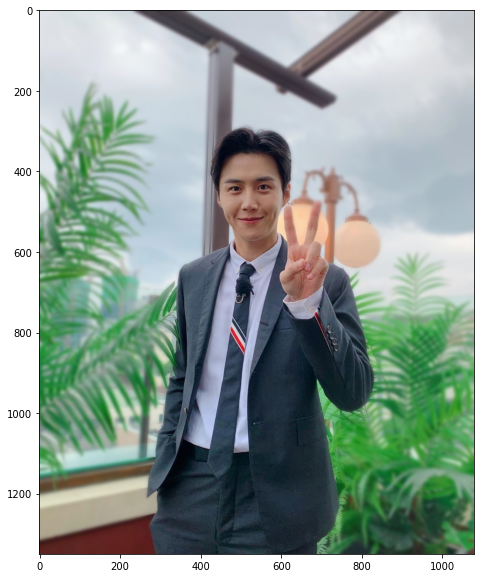

In [44]:
fig = plt.figure(figsize=(25, 10)) 
plt.imshow(cv2.cvtColor(out,cv2.COLOR_BGR2RGB))
ax.set_title('seonho-kim')

plt.show()

경계선이 뚜렷하게 보이는 것은 해결 되었지만 아직도 선호님 손가락까지 완벽하게 검출 못함ㅜㅜ손가락이 블러처리됨ㅜㅜ

## 해결방안 2)

사진마다 해상도도 다르고 완벽하게 물체의 선을 따라서 완벽하게 검출을 하기에는 사실 무리지만 
그래도 해결방안은 있을 것 같아 찾아보던 중에 어느 블로그 글을 발견했다!     
 
이 블로그글에서 CRF(Conditional Random Field)가 등장한다.    
(무슨 모델인지 찾아보니 여러 특징 함수를 섞는 문제를 해결하는 모델이라함)     
일반적으로 short-range CRF는 segmentation을 수행한 뒤 생기는 segmentation잡음을 없애는 용도로 많이 사용되어 왔다고 한다.   
하지만 전체픽셀을 모두 연결한 (fully connected)CRF방법이 개발되었는데 성능이 좋아서 이후에도 후처리에 많이 사용하였다고 함    

- short range CRF
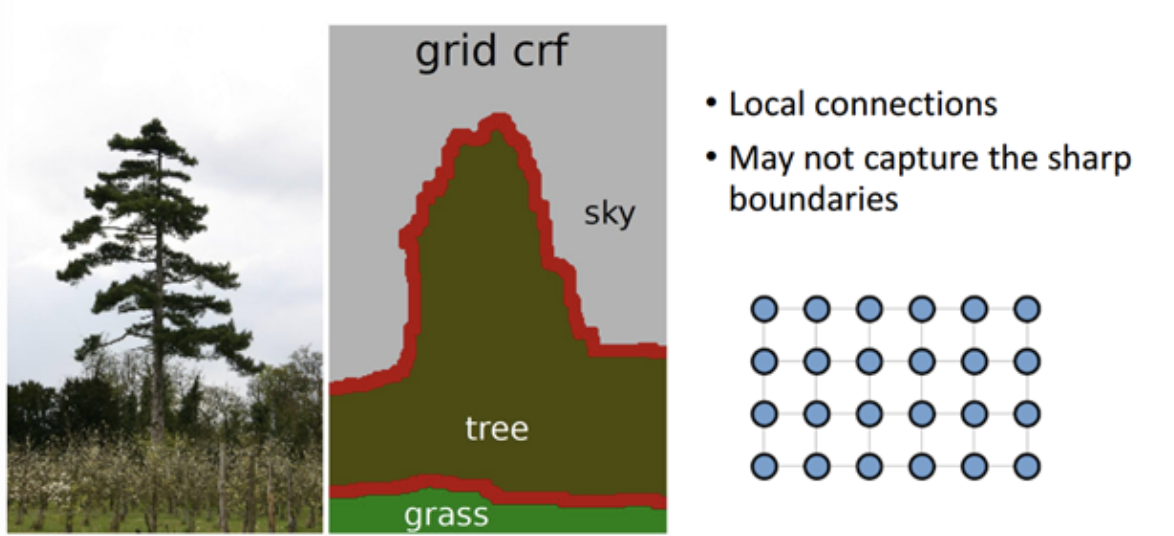


- fully connected CRF
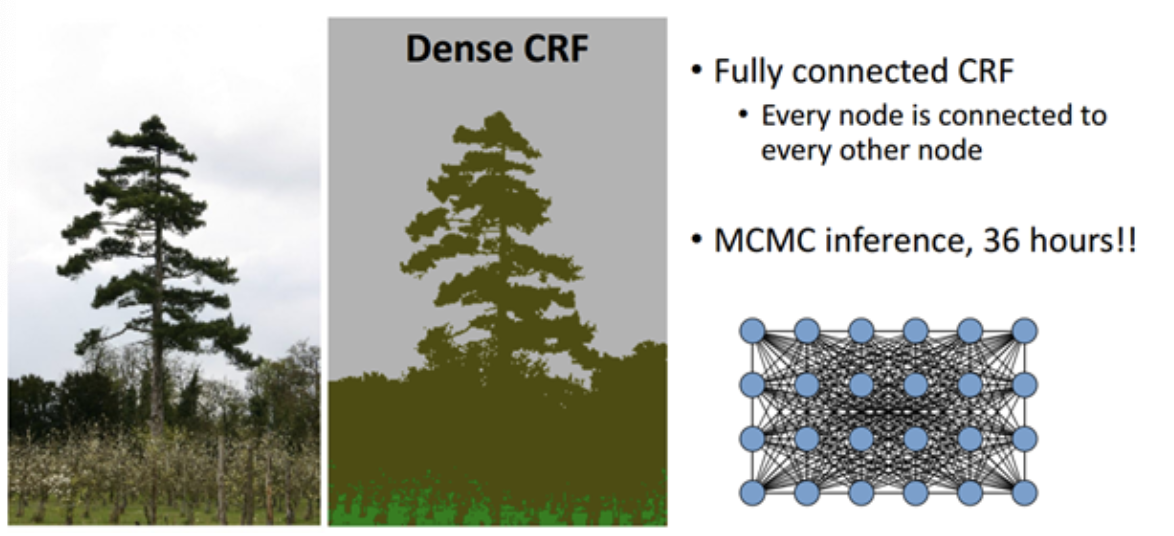

short range CRF는 local connection정보만 사용해서 디테일한 정보를 얻을 수 없지만
두번 째 사진에 fully connected CRF를 사용하면 디테일한 결과물을 얻을 수 있음     

[출처](https://m.blog.naver.com/laonple/221017461464)

# 🌟루브릭

|평가문항|상세문항|
|:------|:---|
|1. 인물모드 사진을 성공적으로 제작하였다.|아웃포커싱 효과가 적용된 본인의 인물모드 사진과 고양이 사진, 배경전환 크로마키사진을 각각 1장 이상 성공적으로 제작하였다.|
|2. 제작한 인물모드 사진들에서 나타나는 문제점을 정확히 지적하였다.|인물사진에서 발생한 문제점을 정확히 지적한 사진을 제출하였다.|
|3. 인물모드 사진의 문제점을 개선할 수 있는 솔루션을 적절히 제시하였다.|추가적인 depth 정보를 활용하여 semantic segmentation mask의 오류를 보완할 수 있는 좋은 솔루션을 구체적으로 제시하였다.|

# 🌟회고

이번 Exploration은 좋아하는 연예인, 강아지, 고양이 사진으로 이미지 검출도 해보고 검출한 이미지를 활용해서 크로마키도 해보기도 해서 그런지 재밌었다!       
재밌었지만 피사계 심도라던지 이런 개념은 생소해서 그런지 관련 링크 내용을 보고 한번에 이해가 가지는 않아서 여러번 보면서 이해를 하려고 했던 것 같다.   
그리고 해결방안을 제시하기 위해서 여러 자료들을 찾아봤는데 위에 적은 CRF처럼 처음 보는 모델들이나 개념, 내용들이 많았다. 시간이 많이 없어서 깊게 알고 넘어가지 않았는데 다시 한번 봐야할 것 같고 segmentation에 대해서 더 자료를 찾아보면서 공부해보고 싶다.

### <참고 자료들>
[출처1](https://locofield.com/5)    

[출처2](https://cinema4dr12.tistory.com/812)     

[출처3](https://ratsgo.github.io/machine%20learning/2017/11/10/CRF/)    

[출처4](https://github.com/PEBpung/Aiffel/blob/master/Project/Exploration/E14.%20Image%20segmentation%EC%9D%84%20%EC%9D%B4%EC%9A%A9%ED%95%9C%20Portrait%20mode%20%EB%A7%8C%EB%93%A4%EA%B8%B0..ipynb)   

[출처5](https://m.blog.naver.com/laonple/221017461464)